In [1]:
import stdpopsim
from matplotlib import pyplot as plt
# Update default font sizes in rcParams
plt.rcParams.update({
    'font.size': 14,         # Default text size
    'axes.titlesize': 18,    # Title font size
    'axes.labelsize': 16,    # X and Y axis labels font size
    'xtick.labelsize': 12,   # X tick labels font size
    'ytick.labelsize': 12,   # Y tick labels font size
    'legend.fontsize': 14,   # Legend font size
    'figure.titlesize': 20   # Figure title font size
})

from glob import glob
import numpy as np
import pandas as pd
from dataclasses import dataclass
import seaborn as sns

In [2]:
@dataclass
class SpeciesInfo:
    """
    Class to store information about species, dfe, demog, and annotation

    species: str - species name
    neu_prop: float - proportion of neutral sites
    nonneu_prop: float - proportion of non-neutral sites
    basedir: str - directory where results are stored
    demog: str - demographic model
    dfe: str - dfe model
    annot: str - annotation used
    """
    species: str
    basedir: str
    demog: str
    dfe: str
    annot: str
    neu_prop: float = 0.3
    nonneu_prop: float = 0.7

    def __post_init__(self):
        self.get_species_info()
        self.make_dfe_dataframe()

    def get_species_info(self):
        species = stdpopsim.get_species(self.species)
        
        if self.annot == "all_sites":
            seq_len = sum([g.length for g in species.genome.chromosomes if g.id not in ["Y", "MT"]])
            annotations = np.array([[0,g.length] for g in species.genome.chromosomes if g.id not in ["Y", "MT"]])
        else:
            annotations = species.get_annotations(self.annot)
            seq_len = 0
            for g in species.genome.chromosomes:
                if g.id not in ["Y", "MT"]:        
                    annot_intervals = annotations.get_chromosome_annotations(g.id)
                    seq_len+= sum([abs(i[1]-i[0]) for i in annot_intervals])
        dfe = species.get_dfe(self.dfe)
        try:
            model = species.get_demographic_model(self.demog)
            if model.mutation_rate is not None:
                mutation_rate = model.mutation_rate
            else:
                mutation_rate = species.genome.mean_mutation_rate
        except:
            mutation_rate = species.genome.mean_mutation_rate
            
        dfe_params = dfe.mutation_types[-1].distribution_args
        self.dfe_params = dfe_params
        self.mutation_rate = mutation_rate
        self.seq_len = seq_len
        self.species_id = species

    def get_loss(self):
        def mae(variable, truth):
            return np.mean(np.abs(variable - truth))

        Es, shape = self.dfe_params
        Es = np.abs(Es)
        mae_Es = self.all_DFE.groupby(['method'])[['Es']].agg(lambda x: mae(x, Es)).reset_index()
        mae_shape = self.all_DFE.groupby(['method'])[['shape']].agg(lambda x: mae(x, shape)).reset_index()
        loss_df = pd.merge(mae_Es, mae_shape, on = 'method')
        lenz = len(loss_df)
        return pd.DataFrame({'MAE E|s|': loss_df['Es'].values,
                'MAE shape': loss_df['shape'].values,
                'method': loss_df['method'].values,
                'species ID': [self.species]*lenz,
                'demography': [self.demog]*lenz,
                'annotation': [self.annot]*lenz})

    ## Rescaling functions
    def grapes_rescale(self, df):
        Ne = df['theta'] / (4 * self.mutation_rate)
        df['Es'] = df['Es'] / Ne
        df['method'] = 'grapes'
        return df

    def dfe_alpha_rescale(self, df):
        df['shape'] = df['b']
        df['Es'] = abs(df['Es'])
        df['method'] = "DFE-alpha"
        return df

    def polydfe_rescale(self, df):
        df['shape'] = df['b']
        df['Es'] = 2 * abs(self.mutation_rate * df['S_d'] / df['theta_bar'])
        df['method'] = "polyDFE" 
        return df 

    def dadi_rescale(self, df):
        df['Es'] = df['shape'] * df['scale'] / (df['theta'] / (4 * self.mutation_rate * self.seq_len * self.nonneu_prop))
        df['method'] = 'dadi'
        return df

    def make_dfe(self, method):
        input_files = glob(f"../{self.basedir}/inference/{self.demog}/{method}/{self.dfe}/{self.annot}/*/*/*bestfit")
        df = pd.concat([pd.read_csv(i, sep="\t") for i in input_files])
        if method == "grapes":
            df = self.grapes_rescale(df)
        elif method == "DFE-alpha":
            df = self.dfe_alpha_rescale(df)
        elif method == "polyDFE":
            df = self.polydfe_rescale(df)
        elif method == "dadi":
            df = self.dadi_rescale(df)
        else:
            raise ValueError(f"Method {method} not recognized")
        return df
    
    def make_dfe_dataframe(self):
        if self.demog == "Constant":
            pop_dict = {f"pop{0}":0}
        else:
            model = self.species_id.get_demographic_model(self.demog)
            pop_dict = {f"pop{i}":m.name for i,m in enumerate(model.populations[:3])}

        all_DFE = pd.concat([self.make_dfe(m) for m in ["grapes", "polyDFE", "dadi"]])
        #make new name columns for viz
        all_DFE['pop'] = all_DFE['pop_id'].map(pop_dict)
        self.all_DFE = all_DFE


def make_some_plots(species_info: SpeciesInfo, output_path = None):
    if output_path is None:
        output_path = f"{species_info.species}_{species_info.demog}_{species_info.dfe}_{species_info.annot}_DFE_plot.pdf"
    
    fig, axes = plt.subplot_mosaic(
        '''
        AB
        ''',
        figsize=(13, 6)
    )
    plt.subplots_adjust(wspace=0.4, hspace=0.3)

    #all_DFE = pd.concat([species_info.make_dfe(m) for m in ["grapes", "polyDFE", "dadi"]])
    #make new name columns for viz
    #all_DFE['pop'] = all_DFE['pop_id'].map(pop_dict)
    #seaborn boxplot method vs. Es split by pop_id no lines, no error bars
    import seaborn as sns
    sns.set_theme(style="whitegrid")
    sns.boxplot(x="method", y="Es", hue = 'pop', data=species_info.all_DFE, ax = axes['A'])
    #horizontal line at 0 on axes A
    axes['A'].axhline(abs(species_info.dfe_params[0]), color='black', linestyle='--')
    axes['A'].set_ylabel('|E(s)|')  
    axes['A'].set_xlabel('Method')
    axes['A'].set_title("A", loc = "left")

    #seaborn boxplot method vs. Es split by pop_id no lines, no error bars
    sns.set_theme(style="whitegrid")
    sns.boxplot(x="method", y="shape", hue = 'pop', data=species_info.all_DFE,  ax = axes['B'])
    #horizontal line at 0
    axes['B'].axhline(abs(species_info.dfe_params[1]), color='black', linestyle='--')
    axes['B'].set_title("B", loc = "left")
    axes['B'].set_ylabel('Shape')
    axes['A'].set_xlabel('Method')
    plt.savefig(output_path)

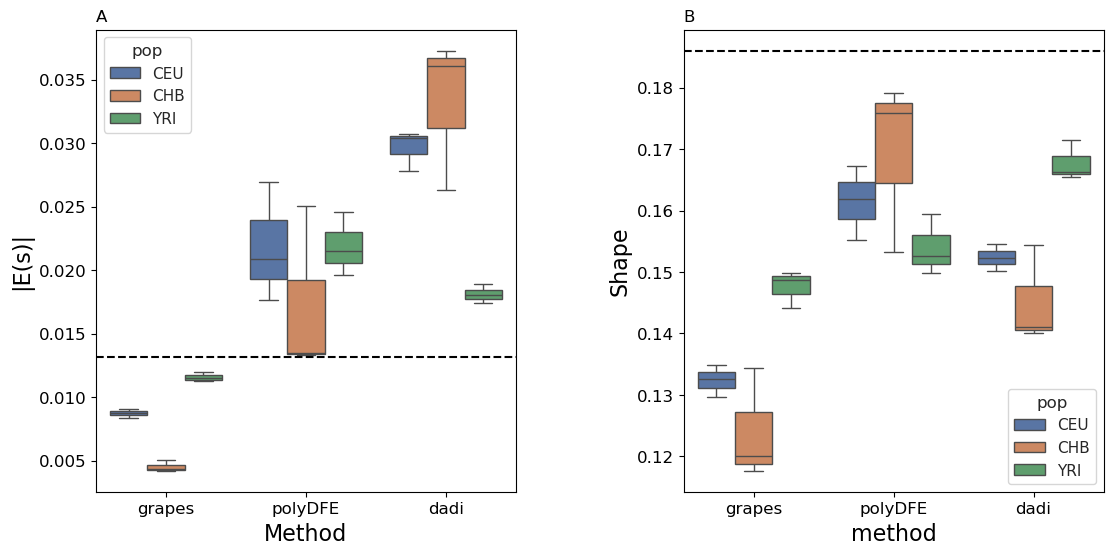

In [3]:
hom_sap = SpeciesInfo(
    species = "HomSap",
    basedir = "HomSap_results",
    demog = "OutOfAfricaArchaicAdmixture_5R19",
    dfe = "Gamma_K17",
    annot = "ensembl_havana_104_exons"
)

#model = stdpopsim.get_species("HomSap").get_demographic_model(hom_sap.demog)
#pop_dict = {f"pop{i}":m.name for i,m in enumerate(model.populations[:3])}
make_some_plots(hom_sap)


loss_list = []
loss_list.append(hom_sap.get_loss())


In [ ]:
hom_sap
Es, shape = hom_sap.dfe_params

def mae(variable, truth):
        return np.mean(np.abs(variable - truth))

mae_Es = hom_sap.all_DFE.groupby(['method'])[['Es']].agg(lambda x: mae(x, Es)).reset_index()
mae_shape = hom_sap.all_DFE.groupby(['method'])[['shape']].agg(lambda x: mae(x, shape)).reset_index()
loss_df = pd.merge(mae_Es, mae_shape, on = 'method')
lenz = len(loss_df)
pd.DataFrame({'MAE E|s|': loss_df['Es'].values,
        'MAE shape': loss_df['shape'].values,
        'method': loss_df['method'].values,
        'species ID': [hom_sap.species]*lenz,
        'demography': [hom_sap.demog]*lenz,
        'annotation': [hom_sap.annot]*lenz})

#print(hom_sap.all_DFE.query('method == "polyDFE"')['mae_Es'].reset_index().mean())
#hom_sap.all_DFE.query('method == "dadi"')['mae_Es'].reset_index().mean()


,MAE E|s|,MAE shape,method,species ID,demography,annotation
0,0.040148,0.030905,dadi,HomSap,OutOfAfricaArchaicAdmixture_5R19,ensembl_havana_104_exons
1,0.021437,0.051345,grapes,HomSap,OutOfAfricaArchaicAdmixture_5R19,ensembl_havana_104_exons
2,0.033484,0.024394,polyDFE,HomSap,OutOfAfricaArchaicAdmixture_5R19,ensembl_havana_104_exons


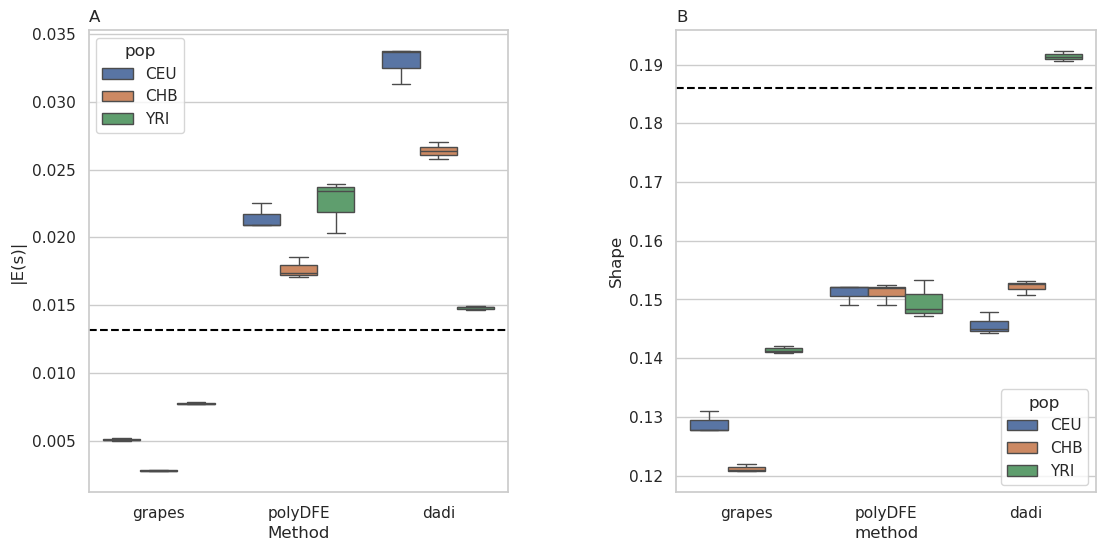

In [5]:
hom_sap = SpeciesInfo(
    species = "HomSap",
    basedir = "HomSap_results",
    demog = "OutOfAfricaArchaicAdmixture_5R19",
    dfe = "Gamma_K17",
    annot = "all_sites"
)

model = stdpopsim.get_species("HomSap").get_demographic_model(hom_sap.demog)
pop_dict = {f"pop{i}":m.name for i,m in enumerate(model.populations[:3])}
make_some_plots(hom_sap)
loss_list.append(hom_sap.get_loss())


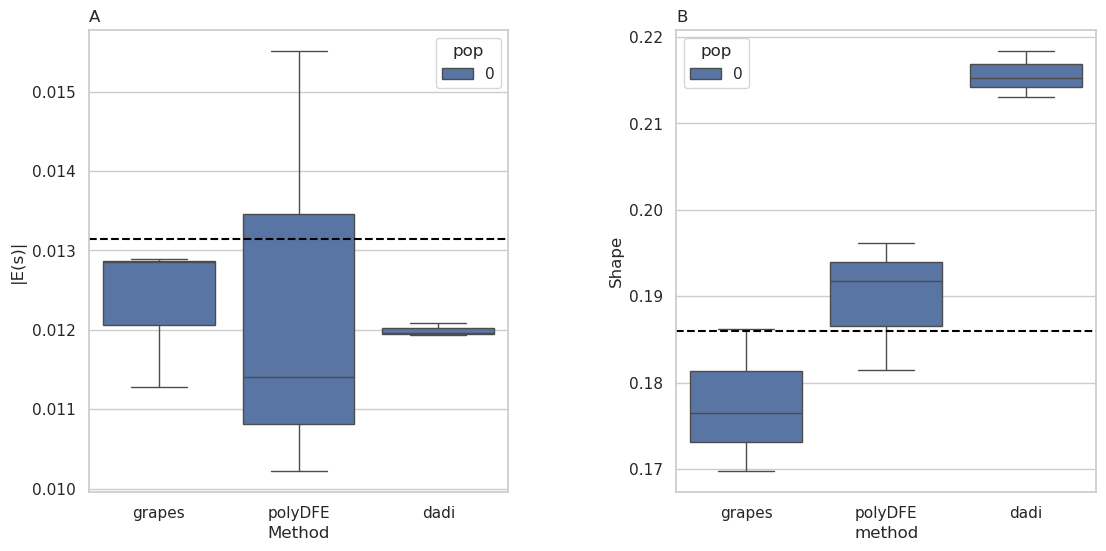

In [6]:
hom_sap = SpeciesInfo(
    species = "HomSap",
    basedir = "HomSap_results",
    demog = "Constant",
    dfe = "Gamma_K17",
    annot = "ensembl_havana_104_exons"
)

make_some_plots(hom_sap)
loss_list.append(hom_sap.get_loss())

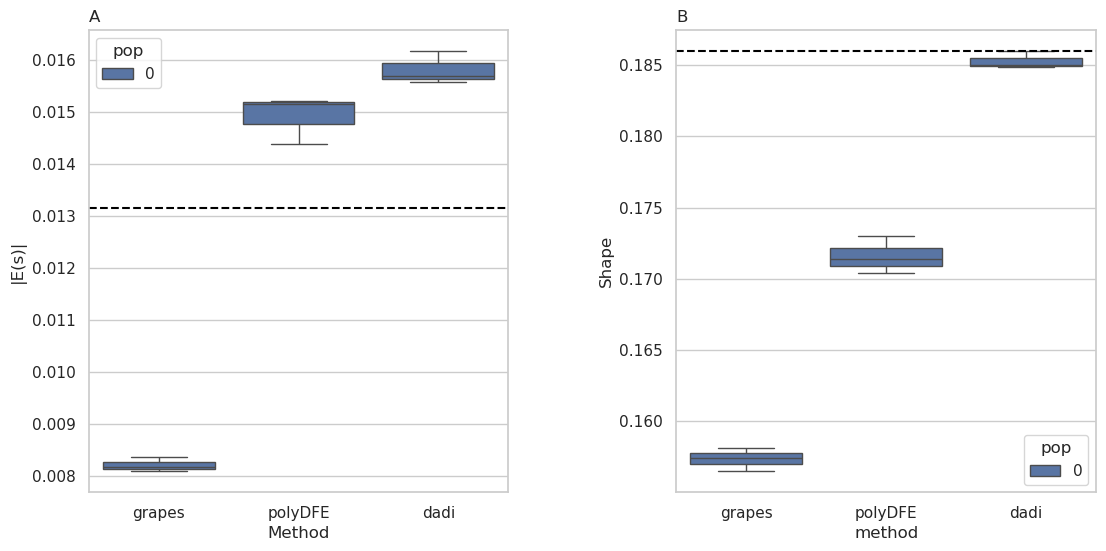

In [7]:
hom_sap = SpeciesInfo(
    species = "HomSap",
    basedir = "HomSap_results",
    demog = "Constant",
    dfe = "Gamma_K17",
    annot = "all_sites"
)

make_some_plots(hom_sap)
loss_list.append(hom_sap.get_loss())

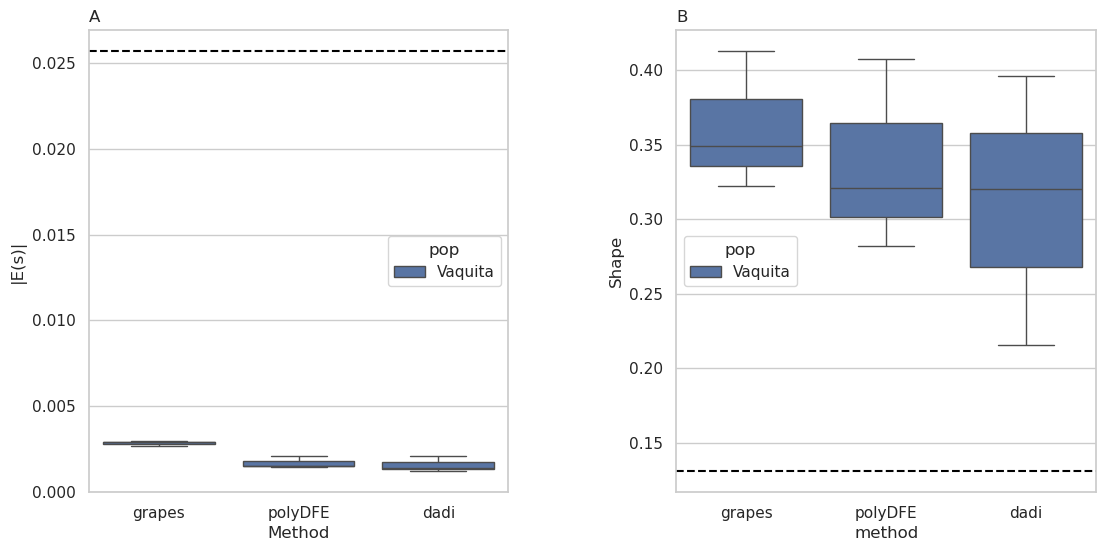

In [8]:
pho_sin = SpeciesInfo(
    species = "PhoSin",
    basedir = "PhoSin_results",
    demog = "Vaquita2Epoch_1R22",
    dfe = "Gamma_R22",
    annot = "Phocoena_sinus.mPhoSin1.pri.110_exons"
)

make_some_plots(pho_sin)
loss_list.append(pho_sin.get_loss())

## EXPLORING H-S RELATIONSHIP ISSUE

In [9]:
#previous version of code 

import numpy as np
import scipy.stats.distributions as ssd
import stdpopsim

def build_hs_plot(ax = None):
    Es = dict(pho_sin.all_DFE.groupby(['method'])[['Es']].agg('mean')["Es"])
    shape = dict(pho_sin.all_DFE.groupby(['method'])[['shape']].agg('mean')["shape"])
                
    phosin = stdpopsim.get_species("PhoSin")
    dfe = phosin.get_dfe("Gamma_R22")
    gamma_mean, gamma_shape = dfe.mutation_types[-1].distribution_args
    print(gamma_mean, gamma_shape)

    #Ryan Gutenkunst's code

    # From https://github.com/popsim-consortium/stdpopsim/blob/main/stdpopsim/catalog/PhoSin/dfes.py
    dominance_coeff_list=[0.0, 0.01, 0.1, 0.4]
    dominance_coeff_breaks=[-0.1, -0.01, -0.001]

    #number of draws for historgram 
    N = int(5e5)

    Ne = phosin.population_size

    # Construct the corresponding gamma distribution
    gamma_scale = -gamma_mean / gamma_shape
    dfe = ssd.gamma(gamma_shape, scale=gamma_scale)
    assert(dfe.mean() == abs(gamma_mean))

    # Simulate draws from the DFE
    s_array = -dfe.rvs(int(1e5))

    # Sanity check, using method of moments to recover simulated shape and scale.
    # (Fixing location parameter to zero.)
    # mean = shape * scale, var = shape * scale**2
    # So scale = var/mean, and shape = mean/scale
    fit_s_scale = s_array.var()/s_array.mean()
    fit_s_shape = s_array.mean()/fit_s_scale
    # Or just use fit_s_shape, _, fit_s_scale = ssd.gamma.fit(s_array, method='MM', floc=0) 
    print('Sanity check: Inferred s shape and mean: {0:.4f}, {1:.5f}'.format(fit_s_shape, fit_s_shape*fit_s_scale))

    # Convert to 2*hs
    breaks = [-np.inf] + list(dominance_coeff_breaks) + [0]
    hs_arrays = []
    for h, s_start, s_end in zip(dominance_coeff_list, breaks[:-1], breaks[1:]):
        hs_arrays.append(2*h*s_array[np.logical_and(s_start < s_array, s_array < s_end)])
    hs_array = np.concatenate(hs_arrays)

    # Calculate mean hs
    mean_hs = hs_array.mean()
    print('Simulated mean 2hs: {0:.6f}'.format(mean_hs))

    #fit_hs_shape, _, fit_hs_scale = ssd.gamma.fit(hs_array, method='MM', floc=0)
    #dfe_hs = ssd.gamma(fit_hs_shape, scale=-fit_hs_scale)
    #
    #print('Inferred 2hs shape and mean: {0:.4f}, {1:.5f}'.format(fit_hs_shape, fit_hs_shape*fit_hs_scale))

    # Results from inferences
    dfe_dadi= ssd.gamma(shape['dadi'], scale=Es['dadi'])
    dfe_polydfe = ssd.gamma(shape['polyDFE'], scale=Es['polyDFE'])
    dfe_grapes = ssd.gamma(shape['grapes'], scale=Es['grapes'])

    # Plotting
    import matplotlib.pyplot as plt
    plt.rc('font', size=10)

    #ax = fig.add_subplot(111)
    #ax = fig.add_subplot(1,1,1)
    # Histogram of 2*hs, scaled by 10^3
    ax.hist(hs_array*Ne, bins=201, density=True, label='Simulated 2hs distribution')
    # DFE inferred for 2hs
    xx = np.linspace(-2.2, 0, 1001)
    #increase line width
    ax.plot(xx, dfe.pdf(-xx/Ne)/Ne, '-k', label='Simulated s distribution', lw=3)
    ax.plot(xx, dfe_dadi.pdf(-xx/Ne)/Ne, '-', label='Inferred DFE (dadi)', lw=3)
    ax.plot(xx, dfe_polydfe.pdf(-xx/Ne)/Ne, '-', label='Inferred DFE (polyDFE)', lw=3)
    ax.plot(xx, dfe_grapes.pdf(-xx/Ne)/Ne, '-', label='Inferred DFE (GRAPES)', lw=3)
    ax.set_xlabel(r'$2hs\,\,N{e}$')
    ax.set_ylabel('Probability density')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 2)
    ax.set_xlim(-2.2,0)
    fig.tight_layout(pad=0)

In [23]:
#updates based on feedback (can probably delete cell above now)

import numpy as np
import scipy.stats.distributions as ssd
import stdpopsim

def build_hs_plot(ax = None):
    Es = dict(pho_sin.all_DFE.groupby(['method'])[['Es']].agg('mean')["Es"])
    shape = dict(pho_sin.all_DFE.groupby(['method'])[['shape']].agg('mean')["shape"])
                
    phosin = stdpopsim.get_species("PhoSin")
    dfe = phosin.get_dfe("Gamma_R22")
    dfe_muts = dfe.mutation_types[-1]
    gamma_mean, gamma_shape = dfe_muts.distribution_args
    print(gamma_mean, gamma_shape)

    dominance_coeff_list = dfe_muts.dominance_coeff_list
    dominance_coeff_breaks = dfe_muts.dominance_coeff_breaks

    # Construct the corresponding gamma distribution
    gamma_scale = -gamma_mean / gamma_shape
    dfe = ssd.gamma(gamma_shape, scale=gamma_scale)
    assert(dfe.mean() == abs(gamma_mean))

    #number of draws for historgram 
    N = int(5e5)

    # Simulate draws from the DFE
    s_array = -dfe.rvs(int(N))

    # Sanity check, using method of moments to recover simulated shape and scale.
    # (Fixing location parameter to zero.)
    # mean = shape * scale, var = shape * scale**2
    # So scale = var/mean, and shape = mean/scale
    fit_s_scale = s_array.var()/s_array.mean()
    fit_s_shape = s_array.mean()/fit_s_scale
    # Or just use fit_s_shape, _, fit_s_scale = ssd.gamma.fit(s_array, method='MM', floc=0) 
    print('Sanity check: Inferred s shape and mean: {0:.4f}, {1:.5f}'.format(fit_s_shape, fit_s_shape*fit_s_scale))

    # Convert to 2*hs
    breaks = [-np.inf] + list(dominance_coeff_breaks) + [0]
    hs_arrays = []
    for h, s_start, s_end in zip(dominance_coeff_list, breaks[:-1], breaks[1:]):
        hs_arrays.append(2*h*s_array[np.logical_and(s_start < s_array, s_array < s_end)])
    hs_array = np.concatenate(hs_arrays)

    # Calculate mean hs
    mean_hs = hs_array.mean()
    print('Simulated mean 2hs: {0:.6f}'.format(mean_hs))

    #fit_hs_shape, _, fit_hs_scale = ssd.gamma.fit(hs_array, method='MM', floc=0)
    #dfe_hs = ssd.gamma(fit_hs_shape, scale=-fit_hs_scale)
    #
    #print('Inferred 2hs shape and mean: {0:.4f}, {1:.5f}'.format(fit_hs_shape, fit_hs_shape*fit_hs_scale))

    # Results from inferences
    dfe_dadi= ssd.gamma(shape['dadi'], scale=Es['dadi'])
    dfe_polydfe = ssd.gamma(shape['polyDFE'], scale=Es['polyDFE'])
    dfe_grapes = ssd.gamma(shape['grapes'], scale=Es['grapes'])

    # Plotting
    import matplotlib.pyplot as plt
    plt.rc('font', size=10)

    #ax = fig.add_subplot(111)
    #ax = fig.add_subplot(1,1,1)
    # Histogram of 2*hs, scaled by 10^3
    ax.hist(hs_array, bins=101, density=True, label='Simulated (2hs)')
    # DFE inferred for 2hs
    xx = np.linspace(-0.0025, 0, 1001)
    #increase line width
    lwds = 2
    alpha = 1.0
    ax.plot(xx, dfe.pdf(-xx), '-k', label='Simulated (s)', lw=lwds, alpha=alpha)
    ax.plot(xx, dfe_dadi.pdf(-xx), '-', label='Inferred DFE (dadi)', lw=lwds, alpha=alpha)
    ax.plot(xx, dfe_polydfe.pdf(-xx), '-', label='Inferred DFE (polyDFE)', lw=lwds, alpha=alpha)
    ax.plot(xx, dfe_grapes.pdf(-xx), '-', label='Inferred DFE (GRAPES)', lw=lwds, alpha=alpha)
    ax.set_xlabel('Selection coefficient')
    ax.set_ylabel('Probability density')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 1500)
    ax.set_xlim(-0.0025,0)
    fig.tight_layout(pad=0)

-0.0257 0.131
Sanity check: Inferred s shape and mean: 0.1310, -0.02572
Simulated mean 2hs: -0.000356


/tmp/ipykernel_3603996/1749325861.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0)


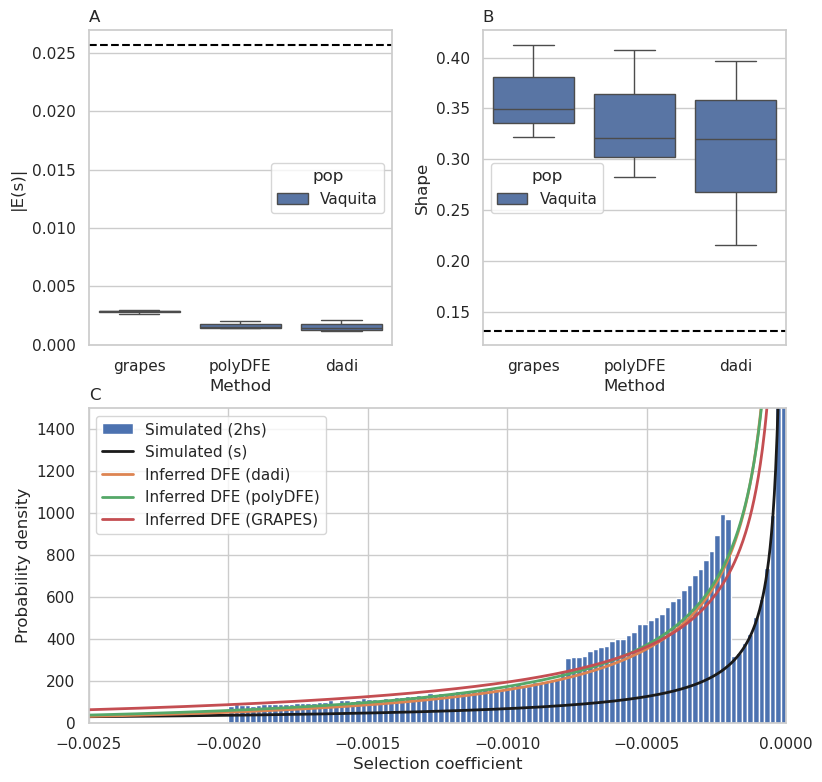

In [28]:
def existing_figure_for_mosaic():
    return {'figure': build_hs_plot()}

layout = [
    ['A', 'B'],
    ['C', 'C']
]

fig, axes = plt.subplot_mosaic(
    layout,
    figsize=(9, 9),
    #white space between subplots
    gridspec_kw={'wspace': 0.3, 'hspace': 0.2}
)

#plt.subplots_adjust(wspace=0.4, hspace=0.3)
#all_DFE = pd.concat([species_info.make_dfe(m) for m in ["grapes", "polyDFE", "dadi"]])
#make new name columns for viz
#all_DFE['pop'] = all_DFE['pop_id'].map(pop_dict)
#seaborn boxplot method vs. Es split by pop_id no lines, no error bars
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.boxplot(x="method", y="Es", hue = 'pop', data=pho_sin.all_DFE, ax = axes['A'])
#horizontal line at 0 on axes A
axes['A'].axhline(abs(pho_sin.dfe_params[0]), color='black', linestyle='--')
axes['A'].set_ylabel('|E(s)|')  
axes['A'].set_xlabel('Method')
axes['A'].set_title("A", loc = "left")
#seaborn boxplot method vs. Es split by pop_id no lines, no error bars
sns.set_theme(style="whitegrid")
sns.boxplot(x="method", y="shape", hue = 'pop', data=pho_sin.all_DFE,  ax = axes['B'])
#horizontal line at 0
axes['B'].axhline(abs(pho_sin.dfe_params[1]), color='black', linestyle='--')
axes['B'].set_title("B", loc = "left")
axes['B'].set_ylabel('Shape')
axes['B'].set_xlabel('Method')
build_hs_plot(axes['C'])
axes['C'].set_title("C", loc = "left")
plt.savefig("PhoSin_Vaquita2Epoch_1R22_Gamma_R22_Phocoena_sinus.mPhoSin1.pri.110_exons_DFE_plot.pdf")

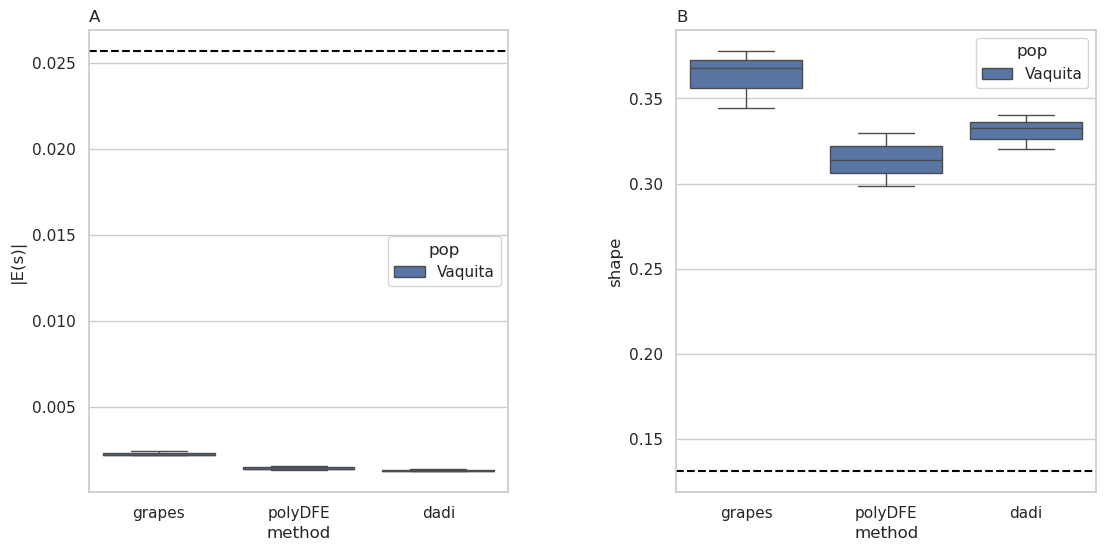

In [9]:
pho_sin = SpeciesInfo(
    species = "PhoSin",
    basedir = "PhoSin_results",
    demog = "Vaquita2Epoch_1R22",
    dfe = "Gamma_R22",
    annot = "all_sites"
)

make_some_plots(pho_sin)
loss_list.append(pho_sin.get_loss())

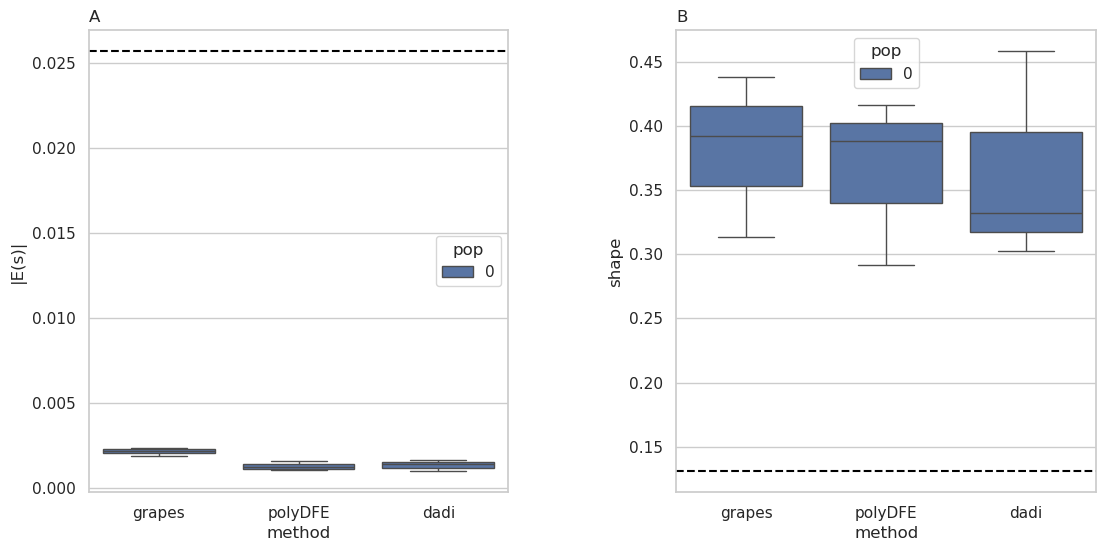

In [10]:
pho_sin = SpeciesInfo(
    species = "PhoSin",
    basedir = "PhoSin_results",
    demog = "Constant",
    dfe = "Gamma_R22",
    annot = "Phocoena_sinus.mPhoSin1.pri.110_exons"
)
make_some_plots(pho_sin)
loss_list.append(pho_sin.get_loss())

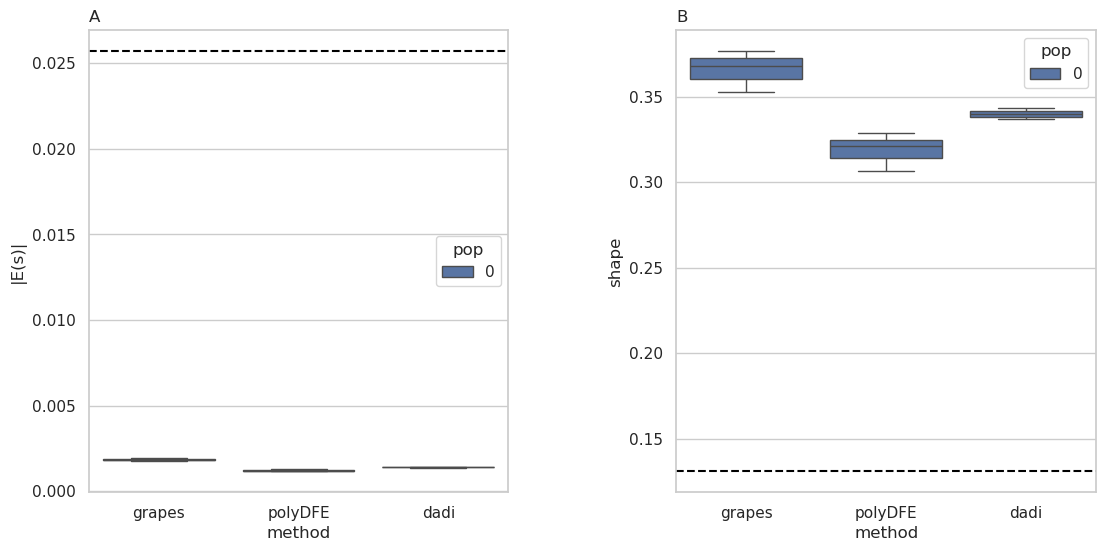

In [11]:
pho_sin = SpeciesInfo(
    species = "PhoSin",
    basedir = "PhoSin_results",
    demog = "Constant",
    dfe = "Gamma_R22",
    annot = "all_sites"
)
make_some_plots(pho_sin)
loss_list.append(pho_sin.get_loss())

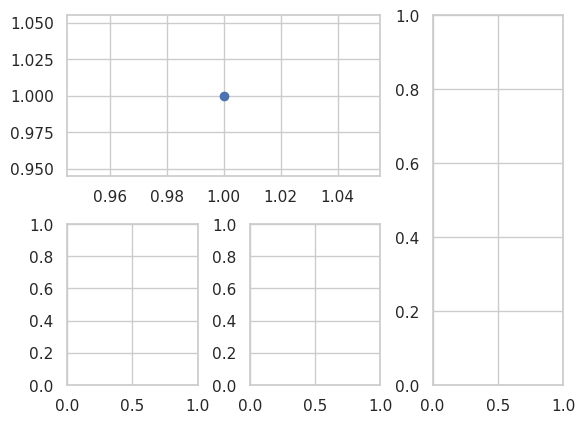

In [12]:
fig, axes = plt.subplot_mosaic(
    '''
    AAE
    CBE
    '''
)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
axes["A"].scatter(1,1)

Text(0, 0.5, 'Expected SFS')

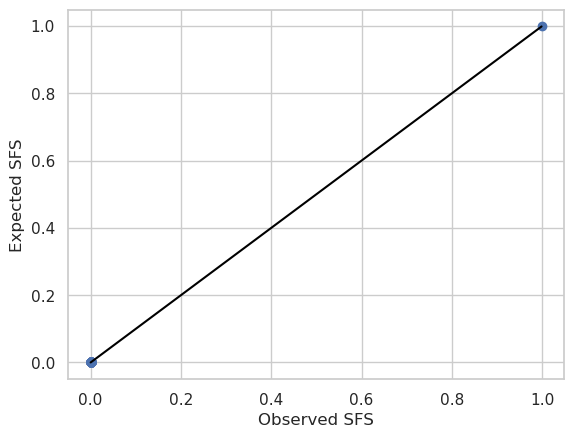

In [13]:
obs_exp = pd.read_csv("/gpfs/projects/kernlab/stittes/analysis2/playground/sel_exp_obs_allele_freqs.csv", sep=" ")
obs_exp.head()
plt.scatter(obs_exp['Observed-SFS'], obs_exp['Expected'])
#one-to-one line
plt.plot([0,np.max(obs_exp['Observed-SFS'])],[0,np.max(obs_exp['Observed-SFS'])], color = 'black')
plt.xlabel("Observed SFS")
plt.ylabel("Expected SFS")


In [14]:
from IPython.display import display
#pandas to latex table
loss_df = pd.concat(loss_list)

display(loss_df.sort_values(by = ['MAE E|s|', 'species ID', 'demography', 'method']).groupby('species ID').head(3))
print("")
display(loss_df.sort_values(by = ['MAE shape', 'species ID', 'demography', 'method']).groupby('species ID').head(3))

loss_df.to_latex()
print("")
loss_df.sort_values(by = ['MAE E|s|'])


loss_df.sort_values(by = ['species ID', 'demography', 'method', 'MAE E|s|', 'MAE shape']).to_latex(index = False)

,MAE E|s|,MAE shape,method,species ID,demography,annotation
1,0.000807,0.008626,grapes,HomSap,Constant,ensembl_havana_104_exons
0,0.001152,0.029568,dadi,HomSap,Constant,ensembl_havana_104_exons
2,0.001773,0.014414,polyDFE,HomSap,Constant,all_sites
1,0.022866,0.230358,grapes,PhoSin,Vaquita2Epoch_1R22,Phocoena_sinus.mPhoSin1.pri.110_exons
1,0.023417,0.232308,grapes,PhoSin,Vaquita2Epoch_1R22,all_sites
1,0.023567,0.250249,grapes,PhoSin,Constant,Phocoena_sinus.mPhoSin1.pri.110_exons


,MAE E|s|,MAE shape,method,species ID,demography,annotation
0,0.002667,0.000712,dadi,HomSap,Constant,all_sites
2,0.002344,0.006828,polyDFE,HomSap,Constant,ensembl_havana_104_exons
1,0.000807,0.008626,grapes,HomSap,Constant,ensembl_havana_104_exons
0,0.024136,0.179650,dadi,PhoSin,Vaquita2Epoch_1R22,Phocoena_sinus.mPhoSin1.pri.110_exons
2,0.024237,0.183145,polyDFE,PhoSin,Vaquita2Epoch_1R22,all_sites
2,0.024476,0.187955,polyDFE,PhoSin,Constant,all_sites


'\\begin{tabular}{rrllll}\n\\toprule\nMAE E|s| & MAE shape & method & species ID & demography & annotation \\\\\n\\midrule\n0.001152 & 0.029568 & dadi & HomSap & Constant & ensembl_havana_104_exons \\\\\n0.002667 & 0.000712 & dadi & HomSap & Constant & all_sites \\\\\n0.000807 & 0.008626 & grapes & HomSap & Constant & ensembl_havana_104_exons \\\\\n0.004931 & 0.028638 & grapes & HomSap & Constant & all_sites \\\\\n0.001773 & 0.014414 & polyDFE & HomSap & Constant & all_sites \\\\\n0.002344 & 0.006828 & polyDFE & HomSap & Constant & ensembl_havana_104_exons \\\\\n0.011556 & 0.026502 & dadi & HomSap & OutOfAfricaArchaicAdmixture_5R19 & all_sites \\\\\n0.013851 & 0.030905 & dadi & HomSap & OutOfAfricaArchaicAdmixture_5R19 & ensembl_havana_104_exons \\\\\n0.004859 & 0.051345 & grapes & HomSap & OutOfAfricaArchaicAdmixture_5R19 & ensembl_havana_104_exons \\\\\n0.007921 & 0.055497 & grapes & HomSap & OutOfAfricaArchaicAdmixture_5R19 & all_sites \\\\\n0.007188 & 0.024394 & polyDFE & HomSap & 

In [15]:
pivot_df = loss_df.pivot_table(index=['species ID', 'demography', 'annotation'], 
                          columns='method', 
                          values=['MAE E|s|', 'MAE shape'])
pivot_df.columns = [f'{val}_{col}' for val, col in pivot_df.columns]
pivot_df.reset_index(inplace=True)
display(pivot_df)
pivot_df.to_latex(index = False)


,species ID,demography,annotation,MAE E|s|_dadi,MAE E|s|_grapes,MAE E|s|_polyDFE,MAE shape_dadi,MAE shape_grapes,MAE shape_polyDFE
0,HomSap,Constant,all_sites,0.002667,0.004931,0.001773,0.000712,0.028638,0.014414
1,HomSap,Constant,ensembl_havana_104_exons,0.001152,0.000807,0.002344,0.029568,0.008626,0.006828
2,HomSap,OutOfAfricaArchaicAdmixture_5R19,all_sites,0.011556,0.007921,0.007422,0.026502,0.055497,0.035366
3,HomSap,OutOfAfricaArchaicAdmixture_5R19,ensembl_havana_104_exons,0.013851,0.004859,0.007188,0.030905,0.051345,0.024394
4,PhoSin,Constant,Phocoena_sinus.mPhoSin1.pri.110_exons,0.024365,0.023567,0.024439,0.233357,0.250249,0.234464
5,PhoSin,Constant,all_sites,0.024292,0.023853,0.024476,0.209159,0.235067,0.187955
6,PhoSin,Vaquita2Epoch_1R22,Phocoena_sinus.mPhoSin1.pri.110_exons,0.024136,0.022866,0.024026,0.179650,0.230358,0.205934
7,PhoSin,Vaquita2Epoch_1R22,all_sites,0.024367,0.023417,0.024237,0.200058,0.232308,0.183145


'\\begin{tabular}{lllrrrrrr}\n\\toprule\nspecies ID & demography & annotation & MAE E|s|_dadi & MAE E|s|_grapes & MAE E|s|_polyDFE & MAE shape_dadi & MAE shape_grapes & MAE shape_polyDFE \\\\\n\\midrule\nHomSap & Constant & all_sites & 0.002667 & 0.004931 & 0.001773 & 0.000712 & 0.028638 & 0.014414 \\\\\nHomSap & Constant & ensembl_havana_104_exons & 0.001152 & 0.000807 & 0.002344 & 0.029568 & 0.008626 & 0.006828 \\\\\nHomSap & OutOfAfricaArchaicAdmixture_5R19 & all_sites & 0.011556 & 0.007921 & 0.007422 & 0.026502 & 0.055497 & 0.035366 \\\\\nHomSap & OutOfAfricaArchaicAdmixture_5R19 & ensembl_havana_104_exons & 0.013851 & 0.004859 & 0.007188 & 0.030905 & 0.051345 & 0.024394 \\\\\nPhoSin & Constant & Phocoena_sinus.mPhoSin1.pri.110_exons & 0.024365 & 0.023567 & 0.024439 & 0.233357 & 0.250249 & 0.234464 \\\\\nPhoSin & Constant & all_sites & 0.024292 & 0.023853 & 0.024476 & 0.209159 & 0.235067 & 0.187955 \\\\\nPhoSin & Vaquita2Epoch_1R22 & Phocoena_sinus.mPhoSin1.pri.110_exons & 0.024136

In [16]:
print(np.min(loss_df[loss_df['species ID'] == "HomSap"]['MAE shape']))
np.min(loss_df[loss_df['species ID'] == "PhoSin"]['MAE shape'])  

0.0007116947786198017


0.17965044653508885